In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data separation/transformation
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE # Recursive Feature Elimination¶

# statistics testing
import scipy.stats as stats

# system manipulation
import itertools
import os
import sys
sys.path.append("./util_")
import prepare_
import explore_

# other
import env
import warnings
warnings.filterwarnings("ignore")

# set the random seed
np.random.seed(95)

**Get data**

In [2]:
# This data is already been split and save
# This is only training data
train_scaled = pd.read_csv("./00_project_data/1-1_training_data.csv", index_col=0)
train_scaled = train_scaled.reset_index(drop=True)
train_scaled.head()

,tax_value,county,los_angeles,orange,ventura,bedrooms_scaled,bathrooms_scaled,sqr_feet_scaled,year_built_scaled,tax_amount_scaled
0,160657.0,Los Angeles,1,0,0,0.428571,0.428571,0.320064,0.405172,0.162429
1,243277.0,Orange,0,1,0,0.428571,0.142857,0.195839,0.448276,0.144717
2,285312.0,Los Angeles,1,0,0,0.428571,0.428571,0.411882,0.491379,0.174333
3,268523.0,Ventura,0,0,1,0.428571,0.285714,0.261252,0.706897,0.147458
4,339115.0,Los Angeles,1,0,0,0.428571,0.285714,0.382877,0.655172,0.217292


## Feature Selection

Use recursive feature elimination to select the top 4 features for predicting tax value.

In [3]:
# separate features from target
xtrain = train_scaled.drop(columns=["tax_value", "county", "tax_amount_scaled"])
ytrain = train_scaled.tax_value

In [4]:
# make a model object to use in RFE process.
linear_model = LinearRegression()

# MAKE the RFE object
rfe = RFE(linear_model, n_features_to_select=1)

# FIT the RFE object to the training data
rfe.fit(xtrain, ytrain)

rfe.ranking_

array([1, 3, 2, 5, 6, 4, 7])

In [5]:
# get a dataframe of all the columns orderd by importance
xtrain_selected = xtrain.iloc[:, rfe.ranking_ - 1]
xtrain_selected.head(3)

# More important to least important

,los_angeles,ventura,orange,bathrooms_scaled,sqr_feet_scaled,bedrooms_scaled,year_built_scaled
0,1,0,0,0.428571,0.320064,0.428571,0.405172
1,0,0,1,0.142857,0.195839,0.428571,0.448276
2,1,0,0,0.428571,0.411882,0.428571,0.491379


In [6]:
xtrain_selected.columns

Index(['los_angeles', 'ventura', 'orange', 'bathrooms_scaled',
       'sqr_feet_scaled', 'bedrooms_scaled', 'year_built_scaled'],
      dtype='object')

## Stats testing

In [7]:
# This data is already been split and save
# This is only training data
train = pd.read_csv("./00_project_data/01_original_clean_no_dummies_train.csv", index_col=0)
train = train.reset_index(drop=True)
train.head()

,bedrooms,bathrooms,sqr_feet,tax_value,year_built,tax_amount,county
0,3,3.0,1601.0,160657.0,1947,3259.81,Los Angeles
1,3,1.0,980.0,243277.0,1952,2905.82,Orange
2,3,3.0,2060.0,285312.0,1957,3497.72,Los Angeles
3,3,2.0,1307.0,268523.0,1982,2960.60,Ventura
4,3,2.0,1915.0,339115.0,1976,4356.32,Los Angeles


**Questions**

1. Is there a linear relationship between the square footage of the property and the tax value?
    - Does the mean tax value differ significantly between properties with different square footage?

2. Do the number of bedrooms or bathrooms impact the tax value?
    - Is there a significant difference in the mean tax value between properties with low numbers of bedrooms or bathrooms against the properties with high numbers of bedrooms or bathrooms
    
3. Does the county where the property is located affect the tax value?
    - Does the mean tax value differ significantly between properties in Los Angeles County compared to the other counties?

- 4. Does the year the property was built have any influence on its tax value?
    - Is there a significant difference in the mean tax value between properties built in different years?


### 1. Is there a linear relationship between the square footage of the property and the tax value?

In [8]:
print("Null_Hyp: There is no a linear relationship between the square footage of the property and the tax value")
print("")
print("Alt_Hyp: There is a linear relationship between the square footage of the property and the tax value")


Null_Hyp: There is no a linear relationship between the square footage of the property and the tax value

Alt_Hyp: There is a linear relationship between the square footage of the property and the tax value


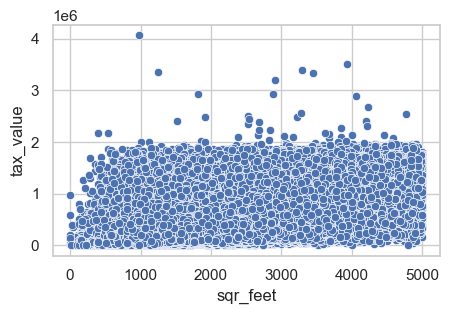

In [9]:
# plot the columns
plt.figure(figsize = (5,3))
sns.scatterplot(data=train, x="sqr_feet", y="tax_value")
plt.show()


In [10]:
# confidence level
alpha = 0.05

# perform the pearson's rcorrelation test
r, p_value = stats.pearsonr(train.sqr_feet, train.tax_value)

# print results
print("coeficient r:", r)
print("p-value:", p_value)
explore_.verify_alpha_(p_value) # compare p-value to alpha

coeficient r: 0.5583485670625855
p-value: 0.0
We have enough evidence to reject the null


- The correlation test shows that there is enough data to say that there is a relationship between square feet and tax valiue and our r-coeficient shows that this relashionship is strong.


**A. Does the mean tax value differ significantly between properties with different square footage**

In [11]:
print("Null_Hyp: The mean tax value differ significantly between properties with different square footage")
print("")
print("Alt_Hyp: The mean tax value does not differ significantly between properties with different square footage")


Null_Hyp: The mean tax value differ significantly between properties with different square footage

Alt_Hyp: The mean tax value does not differ significantly between properties with different square footage


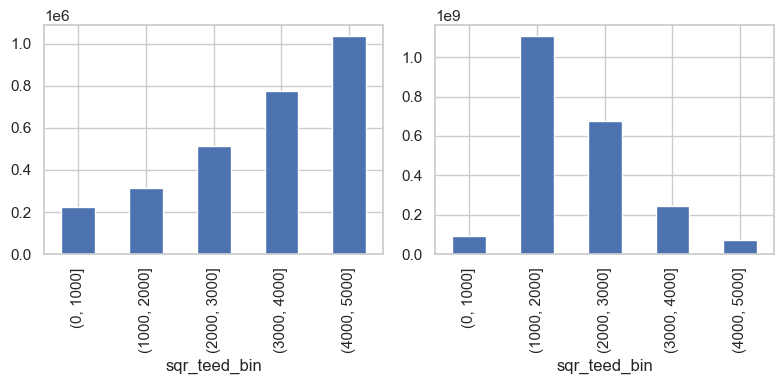

In [12]:
# Define the bin edges
bin_edges = [0, 1000, 2000, 3000, 4000, 5000]

# Create a new column with binned values
train["sqr_teed_bin"] = pd.cut(train.sqr_feet, bins=bin_edges)

# Group the data by the bin column and compute the mean value
grouped_sqr_ft_by_mean_tax_value = train.groupby('sqr_teed_bin').tax_value.mean()
grouped_sqr_ft_by_total_sqr_feet = train.groupby('sqr_teed_bin').sqr_feet.sum()

# Plot the values
fig, ax = plt.subplots(1,2,figsize = (8,4))
grouped_sqr_ft_by_mean_tax_value.plot(kind='bar', ax=ax[0])
grouped_sqr_ft_by_total_sqr_feet.plot(kind="bar", ax=ax[1])
plt.tight_layout()
plt.show()

**Assiptions**

Normal distribution, or at least 30 observations and "kinda" normal for each of the individual groups.

In [13]:
# create the groups to stat test
zero_to_one = train[train.sqr_feet < 1000].sqr_feet
one_to_two = train[(train.sqr_feet >= 1000) & (train.sqr_feet < 2000)].sqr_feet
two_to_three = train[(train.sqr_feet >= 2000) & (train.sqr_feet < 3000)].sqr_feet
three_to_four = train[(train.sqr_feet >= 3000) & (train.sqr_feet < 4000)].sqr_feet
four_to_five = train[(train.sqr_feet >= 4000) & (train.sqr_feet <= 5000)].sqr_feet


**Verify variance quality**

In [14]:
alpha = 0.05

# Verify variance quality
# Perform Levene's test
levene_stat, levene_pvalue = stats.levene(zero_to_one, one_to_two, two_to_three,
                                          three_to_four, four_to_five)

if levene_pvalue > alpha:
    print(f"P-value {levene_pvalue} is greater than alpha: Varience are equal")
else:
     print(f"P-value {levene_pvalue} is less than alpha: Varience are NOT equal")

P-value 0.0 is less than alpha: Varience are NOT equal


**Test statistics**

In [15]:
# Test stats
t_stats, p_value = stats.f_oneway(zero_to_one, one_to_two, two_to_three,
                                          three_to_four, four_to_five)


def Prob_distribution_conclude(t_stats,p_value, alpha=0.05):
    #evaluate p-value
    if (t_stats > 0) and (p_value < alpha):
        print("We reject the null hypothesis")
    else:
        print("We fail to reject the null hypothesis")

Prob_distribution_conclude(t_stats,p_value, alpha)

We reject the null hypothesis


- Stats test show that the mean tax value differ significantly between properties with different square footage

### 2. Do the number of bedrooms or bathrooms impact the tax value?

In [16]:
print("Null_Hyp: The number of bedrooms or bathrooms don't impact the tax value")
print("")
print("Alt_Hyp: The number of bedrooms or bathrooms impact the tax value")


Null_Hyp: The number of bedrooms or bathrooms don't impact the tax value

Alt_Hyp: The number of bedrooms or bathrooms impact the tax value


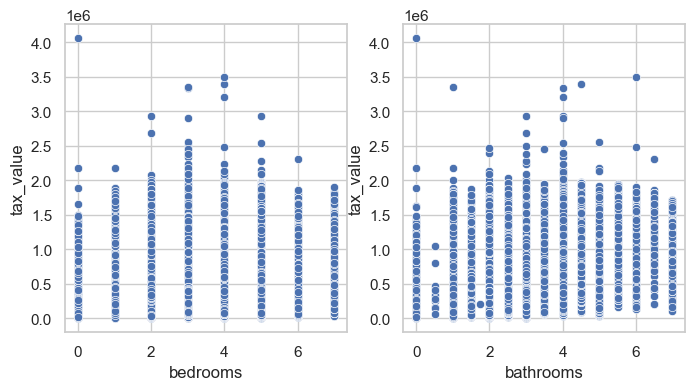

In [17]:
# plot the columns
fig, ax = plt.subplots(1,2,figsize = (8,4))
sns.scatterplot(data=train, x="bedrooms", y="tax_value", ax=ax[0])
sns.scatterplot(data=train, x="bathrooms", y="tax_value", ax=ax[1])
plt.show()


In [18]:
# confidence level
alpha = 0.05

# perform the pearson's rcorrelation test
r, p_value = stats.spearmanr(train.bedrooms, train.tax_value)

# print results
print("coeficient r:", r)
print("p-value:", p_value)
explore_.verify_alpha_(p_value) # compare p-value to alpha

coeficient r: 0.2647001280354298
p-value: 0.0
We have enough evidence to reject the null


In [19]:
# confidence level
alpha = 0.05

# perform the pearson's rcorrelation test
r, p_value = stats.spearmanr(train.bathrooms, train.tax_value)

# print results
print("coeficient r:", r)
print("p-value:", p_value)
explore_.verify_alpha_(p_value) # compare p-value to alpha

coeficient r: 0.442382820770667
p-value: 0.0
We have enough evidence to reject the null


- The spearmanr test shows that there is enough data to say that there is a relationship between bedrooms and tax valiue and our r-coeficient shows that this relashionship is weak.

- The spearmanr test shows that there is enough data to say that there is a relationship between bedrooms and tax valiue and our r-coeficient shows that this relashionship is moderate.

**A. Is there a significant difference in the mean tax value between properties with low numbers of bedrooms or bathrooms against the properties with high numbers of bedrooms or bathrooms**

In [20]:
print("Null_Hyp: There is a significant difference in the mean tax value between properties with low numbers of bedrooms or bathrooms against the properties with high numbers of bedrooms or bathrooms")
print("")
print("Alt_Hyp: There is no a significant difference in the mean tax value between properties with low numbers of bedrooms or bathrooms against the properties with high numbers of bedrooms or bathrooms")


Null_Hyp: There is a significant difference in the mean tax value between properties with low numbers of bedrooms or bathrooms against the properties with high numbers of bedrooms or bathrooms

Alt_Hyp: There is no a significant difference in the mean tax value between properties with low numbers of bedrooms or bathrooms against the properties with high numbers of bedrooms or bathrooms


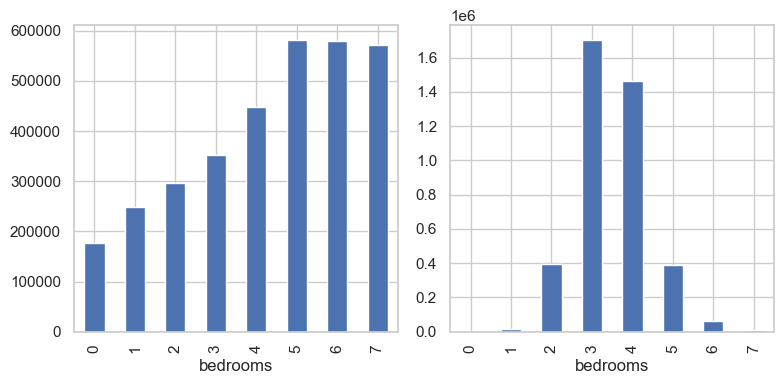

In [21]:
# Group the data by the bin column and compute the mean value
grouped_bedrooms_by_mean_tax_value = train.groupby('bedrooms').tax_value.mean()
grouped_bedrooms_by_total_bedroom_count = train.groupby('bedrooms').bedrooms.sum()

# Plot the values
fig, ax = plt.subplots(1,2,figsize = (8,4))
grouped_bedrooms_by_mean_tax_value.plot(kind='bar', ax=ax[0])
grouped_bedrooms_by_total_bedroom_count.plot(kind="bar", ax=ax[1])
plt.tight_layout()
plt.show()

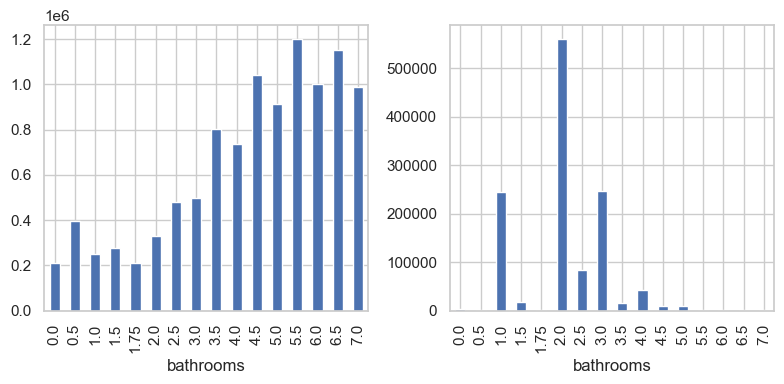

In [22]:
# Group the data by the bin column and compute the mean value
grouped_bathrooms_by_mean_tax_value = train.groupby('bathrooms').tax_value.mean()
grouped_bathrooms_by_total_bedroom_count = train.groupby('bathrooms').bathrooms.count()

# Plot the values
fig, ax = plt.subplots(1,2,figsize = (8,4))
grouped_bathrooms_by_mean_tax_value.plot(kind='bar', ax=ax[0])
grouped_bathrooms_by_total_bedroom_count.plot(kind="bar", ax=ax[1])
plt.tight_layout()
plt.show()

**Assiptions**

Normal distribution, or at least 30 observations and "kinda" normal for each of the individual groups.

In [23]:
# create the groups to stat test
low_bedrooms_tax_value = train[train.bedrooms < 3].tax_value
high_bedrooms_tax_value = train[train.bedrooms > 5].tax_value

alpha = 0.05

# Verify variance quality
# Perform Levene's test
levene_stat, levene_pvalue = stats.levene(low_bedrooms_tax_value, high_bedrooms_tax_value)

if levene_pvalue > alpha:
    print(f"P-value {levene_pvalue} is greater than alpha: Varience are equal")
else:
     print(f"P-value {levene_pvalue} is less than alpha: Varience are NOT equal")

P-value 0.0 is less than alpha: Varience are NOT equal


**Test statistics**

In [24]:
t_stats, p_value = stats.ttest_ind(low_bedrooms_tax_value, high_bedrooms_tax_value)

Prob_distribution_conclude(t_stats,p_value, alpha)

We fail to reject the null hypothesis


- Stat test shows that there is a significant difference in the mean tax value between properties with low numbers of bedrooms or bathrooms against the properties with high numbers of bedrooms or bathrooms

### 3. Does the county where the property is located affect the tax value?

In [25]:
print("Null_Hyp: The county where the property is located does not affect the tax value")
print("")
print("Alt_Hyp: The county where the property is located affect the tax value")


Null_Hyp: The county where the property is located does not affect the tax value

Alt_Hyp: The county where the property is located affect the tax value


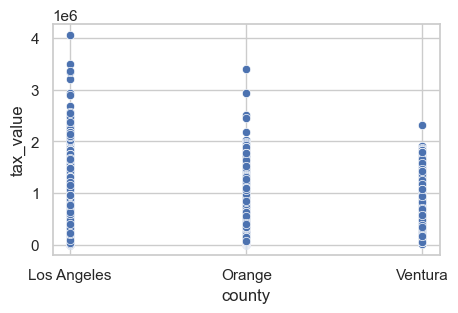

In [26]:
# plot the columns
plt.figure(figsize = (5,3))
sns.scatterplot(data=train, x="county", y="tax_value")
plt.show()


In [27]:
# confidence level
alpha = 0.05

# perform the pearson's rcorrelation test
r, p_value = stats.spearmanr(train.county, train.tax_value)

# print results
print("coeficient r:", r)
print("p-value:", p_value)
explore_.verify_alpha_(p_value) # compare p-value to alpha

coeficient r: 0.16433045595403725
p-value: 0.0
We have enough evidence to reject the null


- The spearmanr test shows that there is enough data to say that there is a relationship between county and tax valiue and our r-coeficient shows that this relashionship is very weak.

**A. Does the mean tax value differ significantly between properties in Los Angeles County compared to the other counties?**

In [47]:
print("Null_Hyp: The mean tax value differ significantly between properties in Los Angeles County compared to the other counties?")
print("")
print("Alt_Hyp: The mean tax value does not differ significantly between properties in Los Angeles County compared to the other counties?")


Null_Hyp: The mean tax value differ significantly between properties in Los Angeles County compared to the other counties?

Alt_Hyp: The mean tax value does not differ significantly between properties in Los Angeles County compared to the other counties?


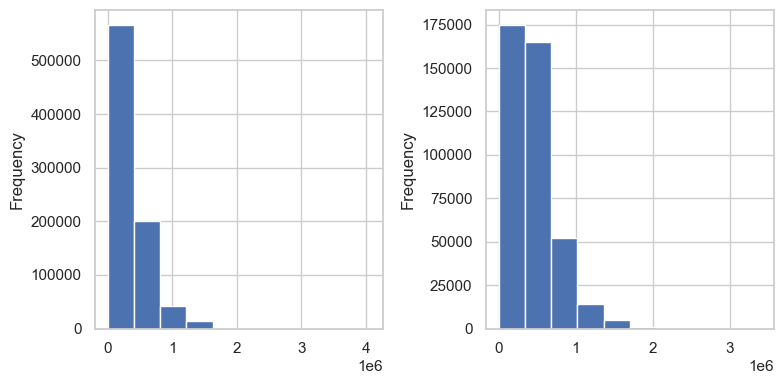

In [53]:
# Group the data by the bin column and compute the mean value
los_angeles_county = train[train.county == "Los Angeles"].tax_value
other_counties = train[train.county != "Los Angeles"].tax_value

# Plot the values
fig, ax = plt.subplots(1,2,figsize = (8,4))
los_angeles_county.plot(kind='hist', ax=ax[0])
other_counties.plot(kind="hist", ax=ax[1])
plt.tight_layout()
plt.show()

**Assiptions**

Not normal distribution

In [54]:
# Verify variance quality
# Perform Levene's test
levene_stat, levene_pvalue = stats.levene(los_angeles_county, other_counties)

if levene_pvalue > alpha:
    print(f"P-value {levene_pvalue} is greater than alpha: Varience are equal")
else:
     print(f"P-value {levene_pvalue} is less than alpha: Varience are NOT equal")

P-value 0.0 is less than alpha: Varience are NOT equal


***Test stats**

In [59]:
t_stats, p_value = stats.mannwhitneyu(los_angeles_county, other_counties)

Prob_distribution_conclude(t_stats,p_value, alpha)

We reject the null hypothesis


- Test show that the mean tax value does not differ significantly between properties in Los Angeles County compared to the other counties?

### 4. Does the year the property was built have any influence on its tax value?

In [32]:
print("Null_Hyp: The year the property was built have no influence on its tax value")
print("")
print("Alt_Hyp: The year the property was built have influence on its tax value")


Null_Hyp: The year the property was built have no influence on its tax value

Alt_Hyp: The year the property was built have influence on its tax value


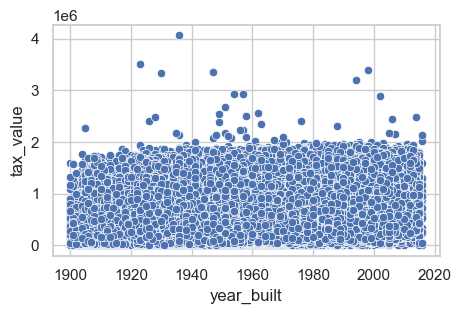

In [33]:
# plot the columns
plt.figure(figsize = (5,3))
sns.scatterplot(data=train, x="year_built", y="tax_value")
plt.show()


In [34]:
# confidence level
alpha = 0.05

# perform the pearson's rcorrelation test
r, p_value = stats.spearmanr(train.year_built, train.tax_value)

# print results
print("coeficient r:", r)
print("p-value:", p_value)
explore_.verify_alpha_(p_value) # compare p-value to alpha

coeficient r: 0.27848067020869854
p-value: 0.0
We have enough evidence to reject the null


- The spearmanr test shows that there is enough data to say that there is a relationship between year built and tax valiue and our r-coeficient shows that this relashionship is very weak.


**A. Is there a significant difference in the mean tax value between properties built in different years?**

In [35]:
print("Null_Hyp: There is a significant difference in the mean tax value between properties built in different years")
print("")
print("Alt_Hyp: There is not a significant difference in the mean tax value between properties built in different years")


Null_Hyp: There is a significant difference in the mean tax value between properties built in different years

Alt_Hyp: There is not a significant difference in the mean tax value between properties built in different years


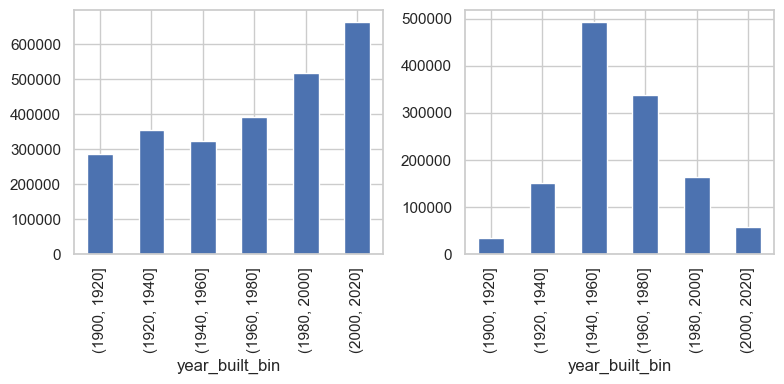

In [40]:
# Define the bin edges
bin_edges = [1900, 1920, 1940, 1960, 1980, 2000, 2020]

# Create a new column with binned values
train["year_built_bin"] = pd.cut(train.year_built, bins=bin_edges)

# Group the data by the bin column and compute the mean value
grouped_year_by_mean_tax_value = train.groupby('year_built_bin').tax_value.mean()
grouped_year_by_total_property_count = train.groupby('year_built_bin').year_built.count()

# Plot the values
fig, ax = plt.subplots(1,2,figsize = (8,4))
grouped_year_by_mean_tax_value.plot(kind='bar', ax=ax[0])
grouped_year_by_total_property_count.plot(kind="bar", ax=ax[1])
plt.tight_layout()
plt.show()

In [42]:
# create the groups to stat test
zero_to_one = train[train.sqr_feet < 1000].sqr_feet
one_to_two = train[(train.year_built >= 1900) & (train.year_built < 1920)].year_built
two_to_three = train[(train.year_built >= 1920) & (train.year_built < 1940)].year_built
three_to_four = train[(train.year_built >= 1940) & (train.year_built < 1960)].year_built
four_to_five = train[(train.year_built >= 1960) & (train.year_built < 1980)].year_built
five_to_six = train[(train.year_built >= 1980) & (train.year_built < 2000)].year_built
six_to_seven = train[(train.year_built >= 2000) & (train.year_built < 2020)].year_built


**Verify variance**

In [43]:
alpha = 0.05

# Verify variance quality
# Perform Levene's test
levene_stat, levene_pvalue = stats.levene(zero_to_one, one_to_two, two_to_three,
                                          three_to_four, four_to_five, five_to_six, six_to_seven)

if levene_pvalue > alpha:
    print(f"P-value {levene_pvalue} is greater than alpha: Varience are equal")
else:
     print(f"P-value {levene_pvalue} is less than alpha: Varience are NOT equal")

P-value 0.0 is less than alpha: Varience are NOT equal


**Test Stats**

In [44]:
# Test stats
t_stats, p_value = stats.f_oneway(zero_to_one, one_to_two, two_to_three,
                                          three_to_four, four_to_five, five_to_six, six_to_seven)


Prob_distribution_conclude(t_stats,p_value, alpha)

We reject the null hypothesis


Test reject null, we have data to say that there is not a significant difference in the mean tax value between properties built in different years.